In [4]:
import cv2
import numpy as np
from cvlib.object_detection import ObjectDetection
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils.Tool import StringUtils, ImageUtils
import os
sns.set_style("white")

In [5]:
detector = ObjectDetection()
image_utils = ImageUtils()
string_utils = StringUtils()

Dectector model is loading...
Dectector model is ready now


In [33]:
from PIL import Image
base_data_path = "./image_data"
list_image = os.listdir(base_data_path)
batch_size = 16
list_image_batch = []
list_name = []
for i in range(0, len(list_image), batch_size):
    list_batch = list_image[i:i+batch_size]
    list_image_b = []
    for image_path in list_batch:
        image = cv2.imread(os.path.join(base_data_path, image_path),1)
        list_image_b.append(image)
        list_name.append(image_path.split(".")[0])
    list_image_batch.append(list_image_b)

In [46]:
res = detector.multi_predict(list_image_batch[0], conf=0.05)

In [29]:
def plot_n_image(images):
    n_images = len(images)

    fig = plt.figure(figsize=(20, 10))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')

In [30]:
def take_plates(image, xxyys):
    plates = []
    for xxyy in xxyys:
        x1, y1, x2, y2 = xxyy
        plate = image_utils.Crop(image, x1, y1, x2-x1, y2-y1)

        plates.append(plate)
    return plates

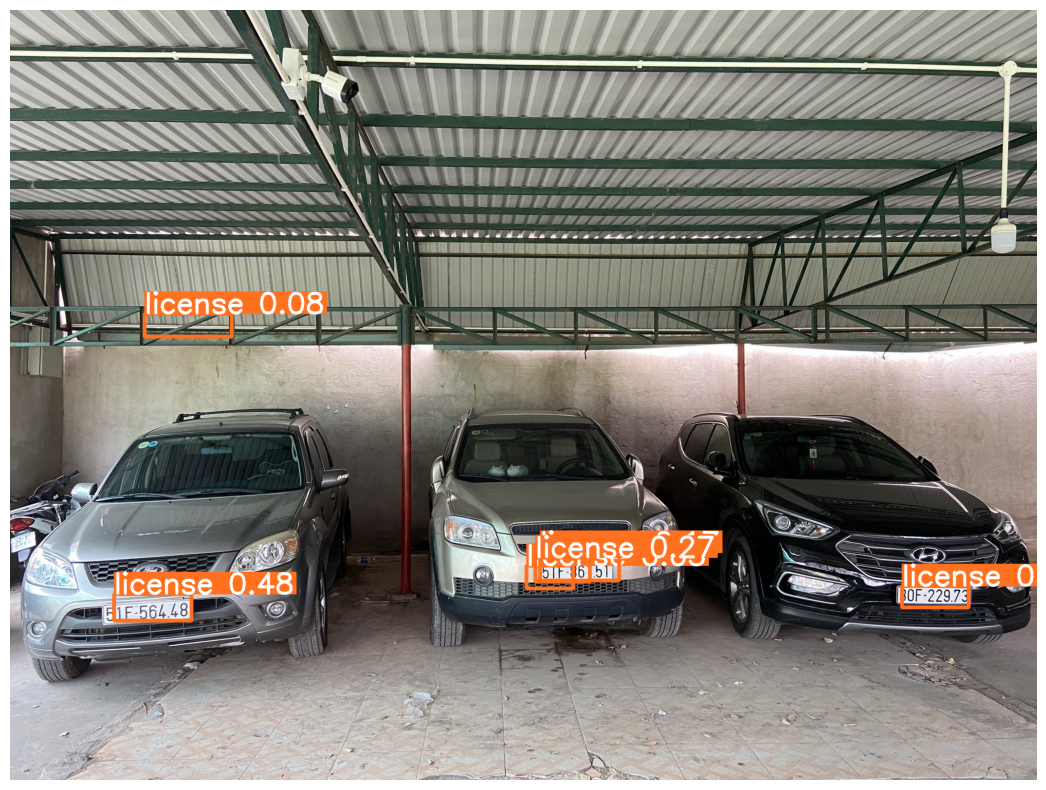

In [49]:
plot_n_image([detector.multi_predict(list_image_batch[0][2], conf=0.05)[0].plot()])

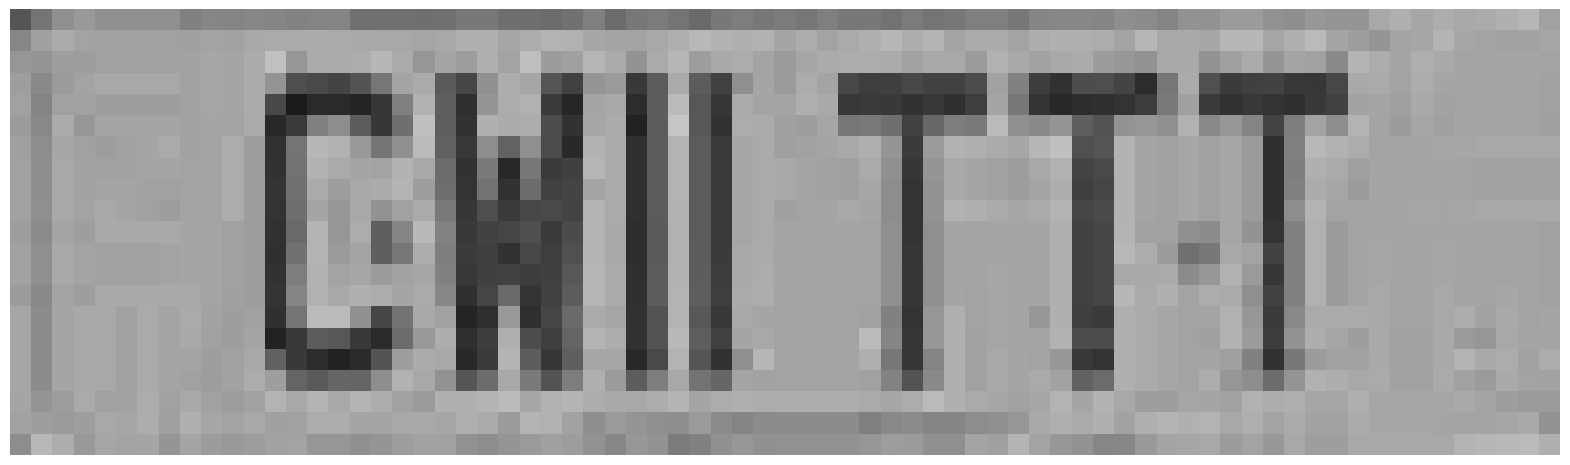

In [48]:
pos = 8
plot_n_image(take_plates(list_image_batch[0][pos], res[pos].numpy().boxes.xyxy.astype(int)))

In [25]:
from paddleocr import PaddleOCR
from utils.Tool import StringUtils, ImageUtils
import cv2
import os
import numpy as np


orc = PaddleOCR(use_angle_cls=True, lang="en")

[2023/06/14 23:56:56] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\drawt/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\drawt/.paddleocr/whl\\rec\\en\\en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, re

In [44]:
result = orc.ocr(take_plates(list_image_batch[0][1], res[0].numpy().boxes.xyxy.astype(int))[0], cls=True)

[2023/06/14 23:59:09] ppocr DEBUG: dt_boxes num : 0, elapse : 0.007002830505371094
[2023/06/14 23:59:09] ppocr DEBUG: cls num  : 0, elapse : 0
[2023/06/14 23:59:09] ppocr DEBUG: rec_res num  : 0, elapse : 0.0


In [31]:
result

[[]]

In [32]:
class VehicleSearch:
    def __init__(self):
        pass
    def get_image(self, path = "./image_data"):
        list_image = os.listdir(path=path)
        batch_size = 16
        self.list_image_batch = []
        self.list_name = []
        for i in range(0, len(list_image), batch_size):
            list_batch = list_image[i:i+batch_size]
            list_image_b = []
            for image_path in list_batch:
                image = cv2.imread(os.path.join(path, image_path))
                list_image_b.append(image)
                self.list_name.append(image_path.split(".")[0])
            self.list_image_batch.append(list_image_b)
    def search(self, input_text, load_image = False):
        """_summary_
        preform search action
        Args:
            input_text (_type_): plate number you want to search
            load_image (bool, optional): reload image or not. Defaults to False.

        Returns:
            original image from cctv: image
            plate image: image
            plate number read from image: string
            bounding box of plate: list
            name of image: string
        """
        if load_image:
            self.get_image()
        for k, batch in enumerate(self.list_image_batch):
            results = detector.multi_predict(batch)
            for i, image in enumerate(batch):
                xxyys = results[i].numpy().boxes.xyxy.astype(int)
                plates = take_plates(image, xxyys)
                for j, plate in enumerate(plates):
                    result = orc.ocr(plate, cls=True)
                    if len(result[0]) == 0:
                        continue
                    text = result[0][0][1][0]
                    text = string_utils.normalize(text)
                    input_text = string_utils.normalize(input_text)
                    if input_text in text:
                        return image, plate, result[0][0][1][0], xxyys[j], self.list_name[k*16+i]
        return None, None, None, None, "No vehicle found" 


In [33]:
seach = VehicleSearch()
seach.get_image()

In [35]:
seach.search("A-12345", load_image=True)

[2023/06/14 23:58:50] ppocr DEBUG: dt_boxes num : 1, elapse : 0.0070040225982666016
[2023/06/14 23:58:50] ppocr DEBUG: cls num  : 1, elapse : 0.010665416717529297
[2023/06/14 23:58:50] ppocr DEBUG: rec_res num  : 1, elapse : 0.09309530258178711
[2023/06/14 23:58:50] ppocr DEBUG: dt_boxes num : 1, elapse : 0.010536909103393555
[2023/06/14 23:58:50] ppocr DEBUG: cls num  : 1, elapse : 0.010001182556152344
[2023/06/14 23:58:50] ppocr DEBUG: rec_res num  : 1, elapse : 0.08973217010498047
[2023/06/14 23:58:50] ppocr DEBUG: dt_boxes num : 1, elapse : 0.011005163192749023
[2023/06/14 23:58:50] ppocr DEBUG: cls num  : 1, elapse : 0.010015010833740234
[2023/06/14 23:58:51] ppocr DEBUG: rec_res num  : 1, elapse : 0.09653401374816895
[2023/06/14 23:58:51] ppocr DEBUG: dt_boxes num : 0, elapse : 0.005973339080810547
[2023/06/14 23:58:51] ppocr DEBUG: cls num  : 0, elapse : 0
[2023/06/14 23:58:51] ppocr DEBUG: rec_res num  : 0, elapse : 0.0


(None, None, None, None, 'No vehicle found')